In [1]:
import pandas as pd 

# Epydemix import
import sys
sys.path.append("../")
from epydemix.epimodel import EpiModel, simulate
from epydemix.calibration import calibration_abc_smc
from epydemix.metrics import wmape
from epydemix.utils import compute_simulation_dates
import numpy as np 
from scipy import stats 
import pyabc 

def compute_contact_reductions(mob_data, columns):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

In [2]:
# import epidemic data 
epi_data = pd.read_csv("./data/london/epi-data/epi_data.csv")

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/london/google-mobility-report/google_mobility_data.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])

In [4]:
# create model 
model = EpiModel(compartments=["S", "E", "I", "R"], population_data_path="./data/london/", population_name="London", contact_layers=["all"])
model.add_parameter(parameters_dict={"beta": 0.04, "mu": 1. / 2.5, "eps": 1. / 4., "r": contact_reductions["r"].values})
model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu")

In [8]:
def custom_initial_conditions(epimodel, I0): 
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {"S": epimodel.population.Nk - infected_by_age, 
            "E": (infected_by_age / 2).astype(int),
            "I": (infected_by_age / 2).astype(int)}


def compute_deaths(simulation_output, 
                   Delta,
                   IFR = [0.00161/100, 0.00695/100, 0.0309/100, 0.0309/100, 0.0844/100, 
                          0.161/100, 0.595/100, 1.93/100, 4.28/100, 7.80/100] , 
                   age_groups=['0-9', '10-19', '20-24', '25-29', '30-39', '40-49', '50-59',
                               '60-69', '70-79', '80+']):
    total_deaths = np.zeros(len(simulation_output[f"R_total"]))
    for i, age in enumerate(age_groups): 
        new_recovered = np.concatenate(([0], np.diff(simulation_output[f"R_{age}"])))
        deaths_age = np.random.binomial(new_recovered, IFR[i])
        deaths_age_shifted = np.zeros_like(deaths_age)
        deaths_age_shifted[Delta:] = deaths_age[:-Delta]
        simulation_output[f"deaths_{age}"] = deaths_age_shifted
        total_deaths += deaths_age_shifted
    simulation_output["deaths_total"] = total_deaths
    return simulation_output


def simulate_wrapper(parameters): 
    # custom initial conditions
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update(initial_conditions)
    # simulate
    results = simulate(**parameters)
    # compute deaths
    results = compute_deaths(results, parameters["Delta"])
    results.update({"data": results["deaths_total"]})
    return results

priors = {"beta": stats.uniform(0.04, 0.1 - 0.04), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(10, 10000)}

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1], steps="daily")
parameters = {"epimodel": model, 
              "simulation_dates": simulation_dates}

results = calibration_abc_smc(model=simulate_wrapper, 
                              priors=priors, 
                              parameters=parameters, 
                              observed_data={"data": epi_data["new_deaths"].values},  
                              num_particles=500, 
                              max_generations=5, 
                              n_jobs=8)

Generation 1: Tolerance = 84.30567360469726, Accepted Particles = 500/500, Time = 00:00:22, ESS = 484.71677994247256
Generation 2: Tolerance = 67.41899130326347, Accepted Particles = 500/996, Time = 00:01:02, ESS = 493.49089023676487
Generation 3: Tolerance = 51.685193462934535, Accepted Particles = 500/1111, Time = 00:01:08, ESS = 244.33788516498825
Generation 4: Tolerance = 39.04540548285276, Accepted Particles = 500/1282, Time = 00:01:24, ESS = 469.1715024538789
Generation 5: Tolerance = 29.682625430160055, Accepted Particles = 500/1475, Time = 00:01:41, ESS = 487.9899170897696


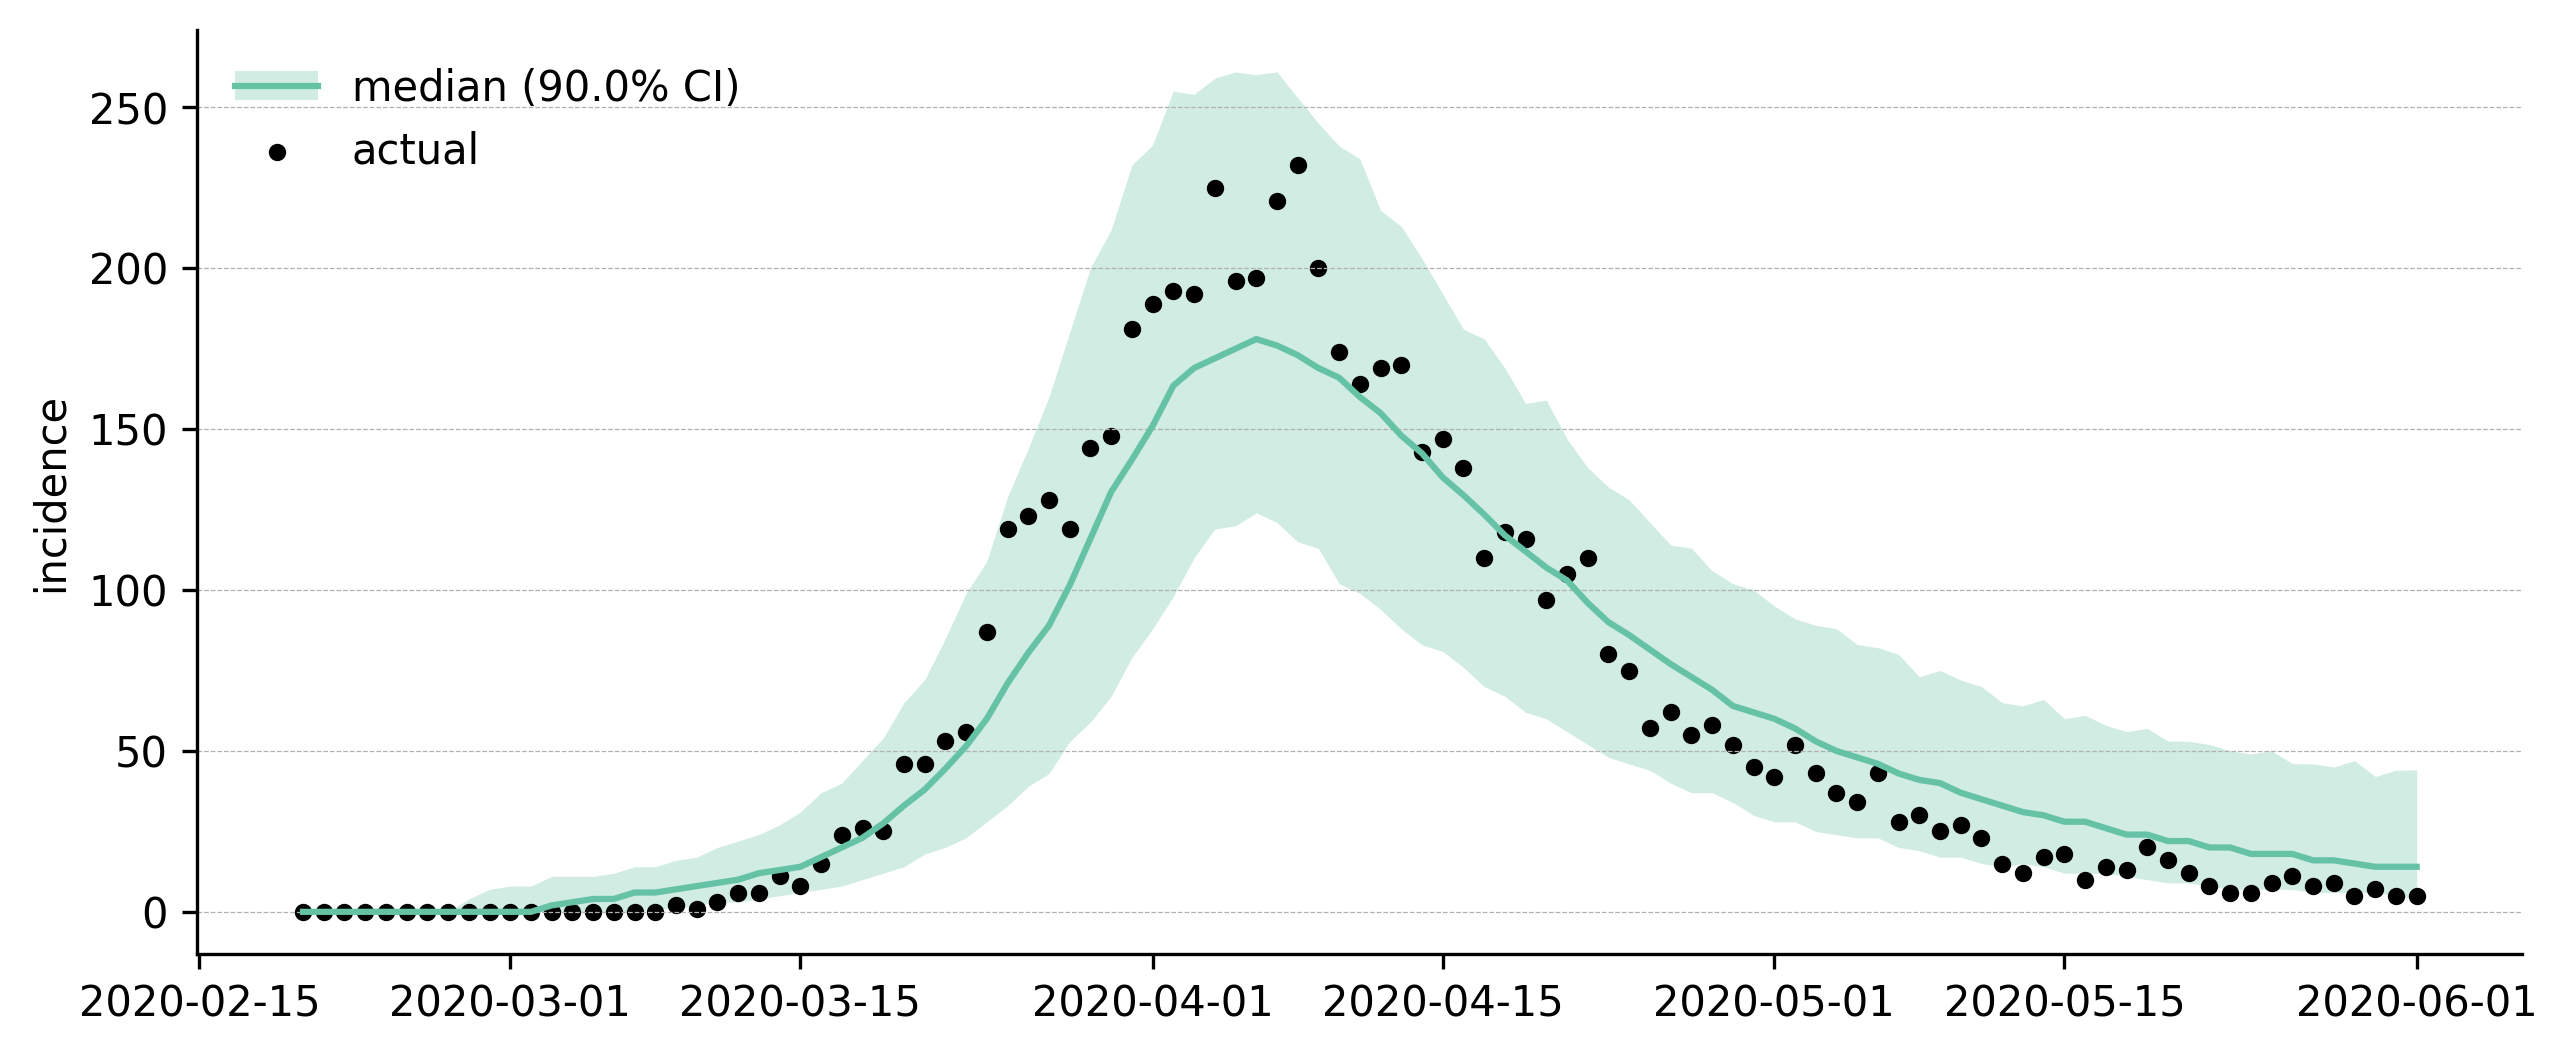

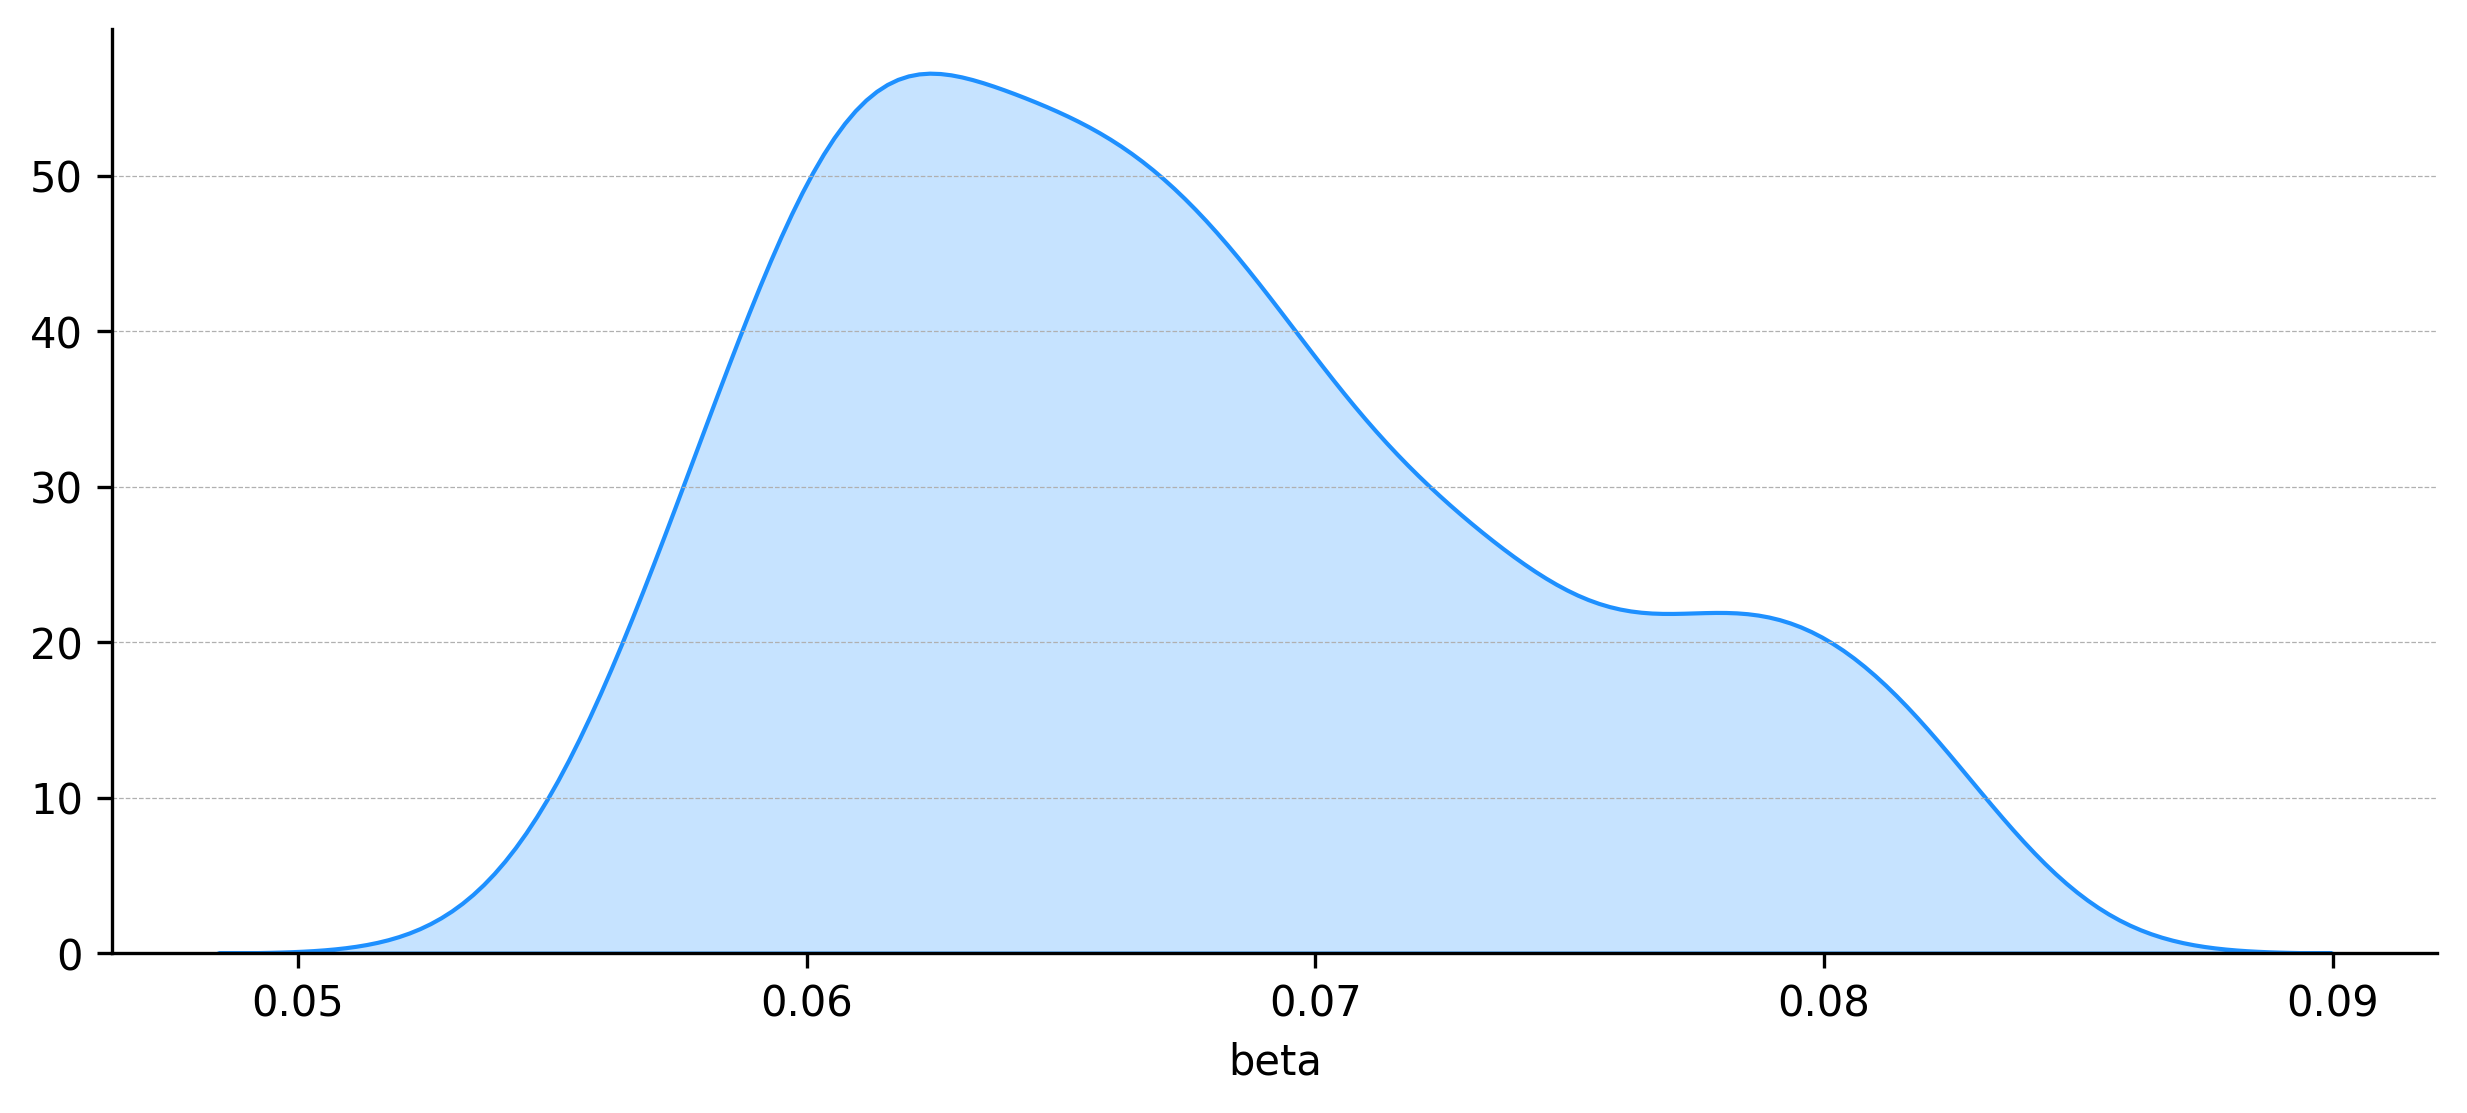

In [9]:
from epydemix.plotting import plot_error_distribution, plot_selected_quantiles, plot_posterior, plot_posterior_2d, plot_selected_trajectories

plot_selected_quantiles(results, ylabel="incidence")
plot_posterior(results, parameter="beta", kind="kde")